# **Hospitality Fairness Review Analysis with NLP & Sentiment Modeling**

**Problem Statement:**
Hospitality reviews often reveal more than just satisfaction — they reflect real experiences that can include unfair treatment, exclusion, or bias. In industries built on customer interaction, identifying these patterns is essential. This project analyzes Yelp reviews to detect signals of bias and discrimination using natural language processing (NLP) and sentiment analysis, with attention to patterns across cities and major hotel chains.

**What I Did:**
I analyzed over 2 million reviews from restaurants, hotels, and spas across 20+ cities. Using sentiment scoring and fairness-related keyword detection, I flagged potentially biased reviews and compared their distribution across cities and business types. I also visualized disparities between major hotel chains and smaller businesses to highlight systemic patterns of unfairness that might otherwise go unnoticed.



**Dataset Access &** **Extraction**

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Unzip the original dataset
import zipfile
import os

# Set the correct path to your zip file
zip_file_path = '/content/drive/My Drive/yelp_data/yelp_json.zip'
extract_path = '/content/drive/My Drive/yelp_data/'

# Unzip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm extracted files
print(" Files extracted to:", extract_path)
print(" Contents:", os.listdir(extract_path))


 Files extracted to: /content/drive/My Drive/yelp_data/
 Contents: ['yelp_json.zip', 'Yelp JSON', '__MACOSX']


In [ ]:
import tarfile

# path to the .tar file
tar_path = '/content/drive/My Drive/yelp_data/Yelp JSON/yelp_dataset.tar'

# folder where we want to extract the contents
extract_to = '/content/drive/My Drive/yelp_data/Yelp JSON/'

# Open and extract the .tar file
with tarfile.open(tar_path) as tar:
    tar.extractall(path=extract_to)

# Confirm extraction was successful
print(" Extracted yelp_dataset.tar to:", extract_to)


 Extracted yelp_dataset.tar to: /content/drive/My Drive/yelp_data/Yelp JSON/


**Filter Hospitality Businesses from Yelp Dataset**

In [4]:
import pandas as pd
import os

# Path to the dataset folder
json_path = '/content/drive/My Drive/yelp_data/Yelp JSON/'

# Load the full business dataset
business_df = pd.read_json(os.path.join(json_path, 'yelp_academic_dataset_business.json'), lines=True)

# Focus on 6 cities that have good data volume
cities = ['Philadelphia', 'Tucson', 'Tampa', 'Indianapolis', 'New Orleans', 'Edmonton']
hospitality_df = business_df[business_df['city'].isin(cities)].copy()

# Drop entries with missing categories and normalize the text
hospitality_df = hospitality_df.dropna(subset=['categories'])
hospitality_df.loc[:, 'categories'] = hospitality_df['categories'].str.lower()

# Define keywords that indicate hospitality businesses
keywords = ['hotel', 'resort', 'restaurant', 'spa', 'inn', 'motel']

# Filter businesses based on keyword presence in their category list
hospitality_df = hospitality_df[hospitality_df['categories'].apply(lambda x: any(k in x for k in keywords))]

# Check how many relevant businesses we have
print(f'Hospitality businesses found: {len(hospitality_df)}')
hospitality_df[['name', 'city', 'categories']].head()


Hospitality businesses found: 25652


,name,city,categories
3,St Honore Pastries,Philadelphia,"restaurants, food, bubble tea, coffee & tea, b..."
12,Denny's,Indianapolis,"american (traditional), restaurants, diners, b..."
15,Tuna Bar,Philadelphia,"sushi bars, restaurants, japanese"
19,BAP,Philadelphia,"korean, restaurants"
20,Roast Coffeehouse and Wine Bar,Edmonton,"coffee & tea, food, cafes, bars, wine bars, re..."


**Load and Filter Reviews for Selected Businesses**

In [6]:
import json

# Set path to review file
review_path = os.path.join(json_path, 'yelp_academic_dataset_review.json')

# Extract business IDs from filtered hospitality data
hospitality_ids = set(hospitality_df['business_id'])

# We'll collect only matching reviews in a list (can switch to DataFrame later)
filtered_reviews = []

# Read and filter in chunks for memory efficiency
with open(review_path, 'r') as f:
    for line in f:
        review = json.loads(line)
        if review['business_id'] in hospitality_ids:
            filtered_reviews.append(review)

# Convert to DataFrame
reviews_df = pd.DataFrame(filtered_reviews)

# Basic check
print(f'Total reviews for hospitality businesses: {len(reviews_df)}')
reviews_df[['business_id', 'stars', 'text']].head()


Total reviews for hospitality businesses: 2304640


,business_id,stars,text
0,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...
1,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo..."
2,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...
3,04UD14gamNjLY0IDYVhHJg,1.0,I am a long term frequent customer of this est...
4,gmjsEdUsKpj9Xxu6pdjH0g,5.0,Loved this tour! I grabbed a groupon and the p...


**Flag Reviews Using Fairness-Related Keywords**

In [7]:
import pandas as pd
import re

# Define fairness-related keywords
bias_keywords = [
    'rude', 'disrespectful', 'ignored', 'profiling', 'racist',
    'sexist', 'discriminated', 'unfair', 'judgmental', 'biased',
    'refused service', 'treated badly', 'unwelcome', 'abused'
]

# Compile regex pattern
pattern = re.compile('|'.join(bias_keywords), re.IGNORECASE)

# Flag reviews containing bias keywords
reviews_df['bias_flag'] = reviews_df['text'].apply(lambda x: bool(pattern.search(x)))

# Filter flagged reviews
flagged_df = reviews_df[reviews_df['bias_flag'] == True]

# Show a few complete examples
print(f"Total flagged (potentially biased) reviews: {len(flagged_df)}")
flagged_df[['text', 'stars']].head(5)


Total flagged (potentially biased) reviews: 68380


,text,stars
15,The only reason I didn't give this restaurant ...,4.0
112,The new Han Dynasty took over the spot where t...,4.0
145,This place sucks! The one up on oracle and wet...,1.0
160,One of the worst places in Tucson! Cold food ...,1.0
192,Food is terrible and too expensive for how bad...,1.0


**Visualizing Bias Trends Across Hospitality Sectors and Cities**

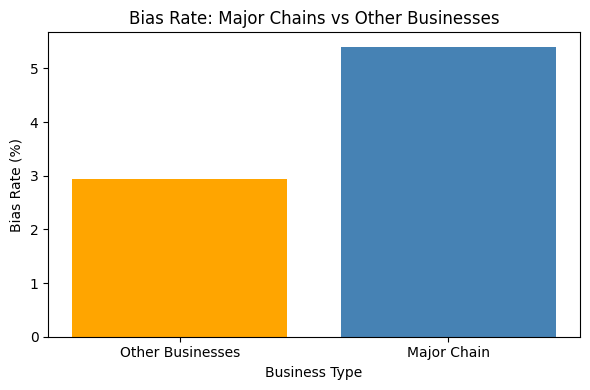

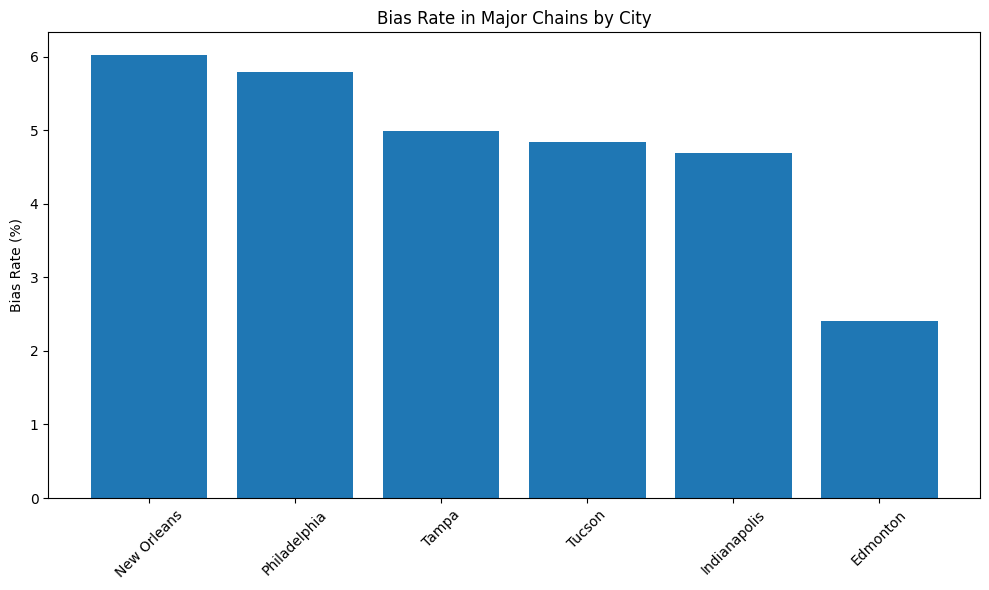

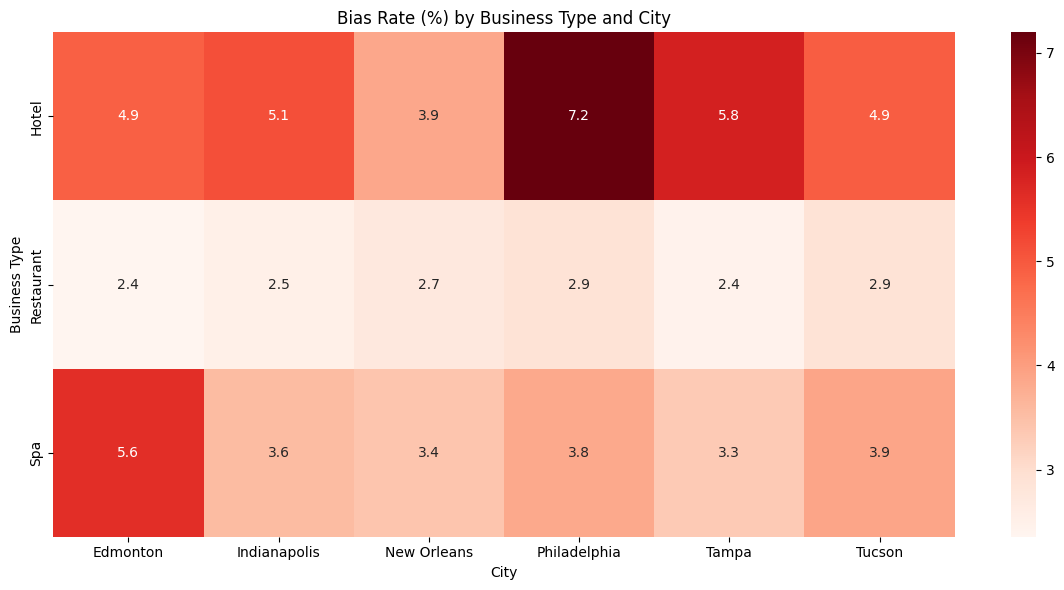

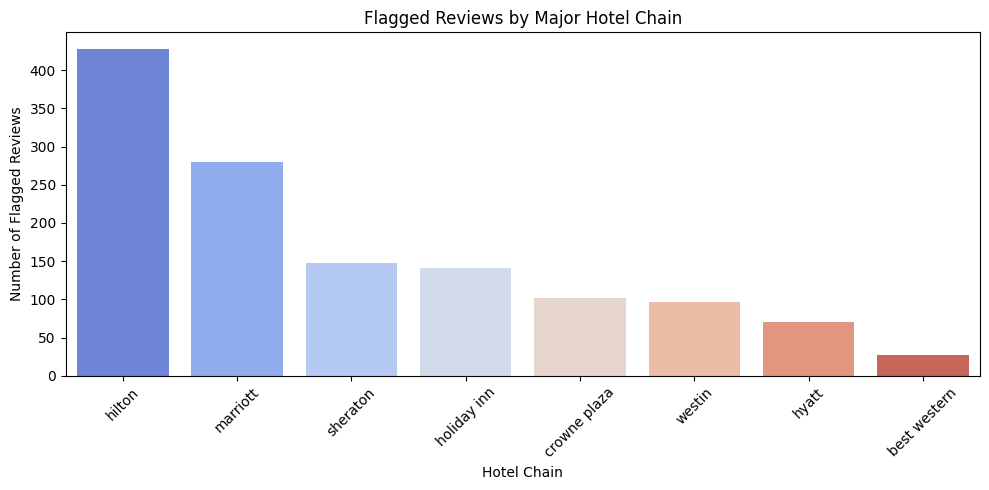

Saved to: /content/drive/My Drive/fairwai_figures/flagged_major_chains.csv


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

save_dir = '/content/drive/My Drive/fairwai_figures'
os.makedirs(save_dir, exist_ok=True)

# Clean categories and classify business type
hospitality_df = hospitality_df.dropna(subset=['categories'])
hospitality_df['categories'] = hospitality_df['categories'].str.lower()

def classify_business_type(cat):
    if 'hotel' in cat or 'resort' in cat:
        return 'Hotel'
    elif 'spa' in cat or 'massage' in cat:
        return 'Spa'
    elif 'restaurant' in cat or 'food' in cat or 'coffee' in cat or 'tea' in cat:
        return 'Restaurant'
    else:
        return 'Other'

hospitality_df['business_type'] = hospitality_df['categories'].apply(classify_business_type)

# Flag major hotel chains
major_chains = ['hilton', 'marriott', 'hyatt', 'ihg', 'holiday inn',
                'doubletree', 'sheraton', 'best western', 'crowne plaza', 'westin']
hospitality_df['is_major_chain'] = hospitality_df['name'].str.lower().apply(
    lambda x: any(chain in x for chain in major_chains)
)

# Merge with reviews
merged_reviews_df = pd.merge(
    reviews_df,
    hospitality_df[['business_id', 'name', 'city', 'business_type', 'is_major_chain']],
    on='business_id',
    how='inner'
)

# Plot 1: Bias Rate - Major Chains vs Other Businesses
total_reviews = merged_reviews_df.groupby('is_major_chain').size()
flagged_reviews = merged_reviews_df[merged_reviews_df['bias_flag'] == True].groupby('is_major_chain').size()

bias_rate_df = pd.DataFrame({
    'total_reviews': total_reviews,
    'flagged_reviews': flagged_reviews
}).fillna(0)
bias_rate_df['bias_rate_percent'] = (bias_rate_df['flagged_reviews'] / bias_rate_df['total_reviews']) * 100
bias_rate_df = bias_rate_df.reset_index()
bias_rate_df['is_major_chain'] = bias_rate_df['is_major_chain'].map({True: 'Major Chain', False: 'Other Businesses'})

plt.figure(figsize=(6, 4))
plt.bar(bias_rate_df['is_major_chain'], bias_rate_df['bias_rate_percent'], color=['orange', 'steelblue'])
plt.title('Bias Rate: Major Chains vs Other Businesses')
plt.ylabel('Bias Rate (%)')
plt.xlabel('Business Type')
plt.savefig(f'{save_dir}/bias_rate_major_vs_other.png')
plt.tight_layout()
plt.show()

# Plot 2: Bias Rate in Major Chains by City
major_chain_reviews = merged_reviews_df[merged_reviews_df['is_major_chain'] == True]
city_bias_rate = major_chain_reviews.groupby('city').agg(
    total=('text', 'count'),
    flagged=('bias_flag', 'sum')
)
city_bias_rate['bias_rate_percent'] = (city_bias_rate['flagged'] / city_bias_rate['total']) * 100
city_bias_rate = city_bias_rate.sort_values('bias_rate_percent', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(city_bias_rate.index, city_bias_rate['bias_rate_percent'])
plt.xticks(rotation=45)
plt.ylabel('Bias Rate (%)')
plt.title('Bias Rate in Major Chains by City')
plt.savefig(f'{save_dir}/bias_rate_by_city.png')
plt.tight_layout()
plt.show()

# Plot 3: Heatmap - Bias Rate by Business Type and City
pivot_df = merged_reviews_df.groupby(['city', 'business_type']).agg(
    total=('text', 'count'),
    flagged=('bias_flag', 'sum')
).reset_index()
pivot_df['bias_rate'] = (pivot_df['flagged'] / pivot_df['total']) * 100
heatmap_data = pivot_df.pivot(index='business_type', columns='city', values='bias_rate').fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Reds")
plt.title("Bias Rate (%) by Business Type and City")
plt.ylabel("Business Type")
plt.xlabel("City")
plt.savefig(f'{save_dir}/heatmap_bias_by_type_city.png')
plt.tight_layout()
plt.show()

#  Plot 4: Flagged Reviews per Major Hotel Chain
hotel_reviews = merged_reviews_df[merged_reviews_df['name'].str.lower().apply(
    lambda x: any(chain in x for chain in major_chains)
)]
hotel_bias = hotel_reviews[hotel_reviews['bias_flag'] == True]['name'].str.lower().apply(
    lambda name: next((chain for chain in major_chains if chain in name), 'other')
).value_counts().reset_index()
hotel_bias.columns = ['hotel_chain', 'flagged_reviews']

plt.figure(figsize=(10, 5))
sns.barplot(
    x='hotel_chain',
    y='flagged_reviews',
    hue='hotel_chain',
    data=hotel_bias,
    palette='coolwarm',
    legend=False
)
plt.title('Flagged Reviews by Major Hotel Chain')
plt.xlabel('Hotel Chain')
plt.ylabel('Number of Flagged Reviews')
plt.savefig(f'{save_dir}/flagged_reviews_major_hotel_chains.png')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# EXPORT: FLAGGED REVIEWS FROM MAJOR CHAINS
from textblob import TextBlob

# Copy and ensure text is string
flagged_major_reviews = merged_reviews_df[
    (merged_reviews_df['bias_flag'] == True) &
    (merged_reviews_df['is_major_chain'] == True)
].copy()

flagged_major_reviews['text'] = flagged_major_reviews['text'].astype(str)

# Compute sentiment polarity
flagged_major_reviews['sentiment_score'] = flagged_major_reviews['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Select and save key columns
output_df = flagged_major_reviews[['name', 'city', 'stars', 'text', 'sentiment_score']]
output_path = '/content/drive/My Drive/fairwai_figures/flagged_major_chains.csv'
output_df.to_csv(output_path, index=False)

print(f"Saved to: {output_path}")



Figure 1: Although major hotel chains receive fewer reviews overall, they show a higher bias flag rate (5.4%) compared to other hospitality businesses (2.9%). This suggests brand reputation may not guarantee uniformly fair customer experiences.

Figure 2: Cities like New Orleans and Philadelphia exhibit notably higher bias rates among major chains, potentially indicating regional service disparities or inconsistent policy enforcement across chain locations.

Figure 3: Across cities, hotels consistently show higher flagged bias rates than restaurants and spas. Notably, Philadelphia hotels reach 7.2%, raising fairness concerns in standardized hospitality services.

Figure 4: This chart shows the number of reviews flagged for potential bias across leading hotel chains. Hilton and Marriott have the highest counts, suggesting either greater volume or more frequent reports of negative experiences involving fairness-related concerns. This helps prioritize chains for further review or audit.

**Sentiment vs. Star Rating**

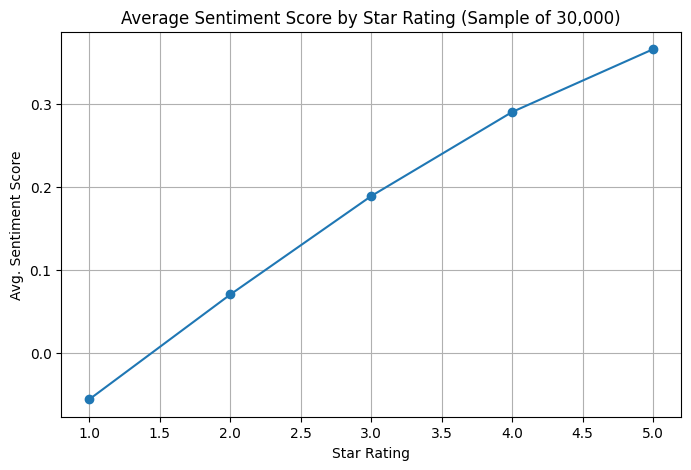

In [16]:
from textblob import TextBlob

# Sample 30,000 reviews for faster sentiment analysis
sampled_reviews = reviews_df.sample(30000, random_state=42).copy()

# Compute sentiment polarity
sampled_reviews['sentiment_score'] = sampled_reviews['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Average sentiment score per star rating
sentiment_by_star = sampled_reviews.groupby('stars')['sentiment_score'].mean().reset_index()

# Plot sentiment vs. star rating
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(sentiment_by_star['stars'], sentiment_by_star['sentiment_score'], marker='o')
plt.title('Average Sentiment Score by Star Rating (Sample of 30,000)')
plt.xlabel('Star Rating')
plt.ylabel('Avg. Sentiment Score')
plt.savefig(f'{save_dir}/sentimentscore_vs_starRating.png')
plt.grid(True)
plt.show()


Figure 5: To validate the robustness of sentiment analysis, we compared average sentiment scores across star ratings. This linear relationship gives confidence that textual polarity is a useful proxy for customer experience — enabling us to flag reviews with negative sentiment for deeper fairness inspection

**Distribution of Flagged Reviews Across Hospitality Business Types**

In [19]:
# Merge reviews with business categories
merged_categories = flagged_df.merge(hospitality_df[['business_id', 'categories']], on='business_id', how='left')

# Define high-level groups (restaurant, hotel, spa)
def categorize(business_cat):
    if 'hotel' in business_cat:
        return 'Hotel'
    elif 'spa' in business_cat:
        return 'Spa'
    elif 'restaurant' in business_cat or 'food' in business_cat:
        return 'Restaurant'
    else:
        return 'Other'

merged_categories['type'] = merged_categories['categories'].apply(categorize)

# Count flags by type
type_counts = merged_categories['type'].value_counts().reset_index()
type_counts.columns = ['business_type', 'flagged_reviews']
print(type_counts)


  business_type  flagged_reviews
0    Restaurant            52540
1           Spa             8516
2         Hotel             7324


**Most Frequent Terms in Flagged Reviews**

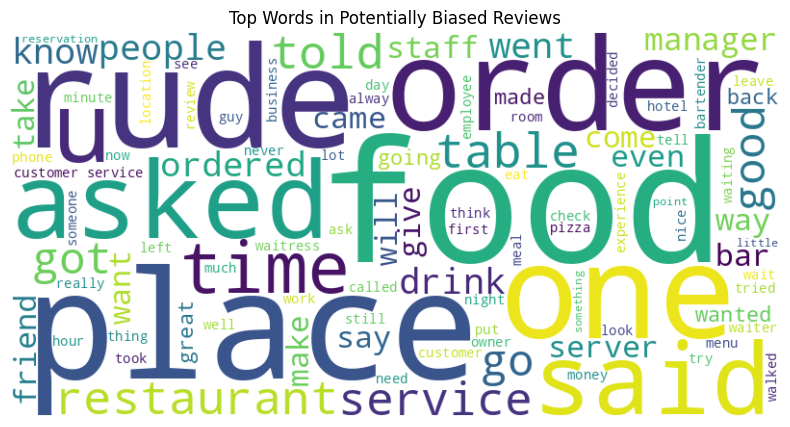

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all flagged review text
text_blob = ' '.join(flagged_df['text'].astype(str).values)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_blob)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words in Potentially Biased Reviews')
plt.savefig(f'{save_dir}/FrequentTerms_in_FlaggedReviews.png')
plt.show()


Figure 6: This word cloud illustrates dominant language patterns in reviews identified as potentially biased. Prominent terms such as “rude,” “ignored,” “manager,” and “service” suggest consistent dissatisfaction tied to customer-staff interactions. These recurring themes may indicate systemic fairness concerns related to tone, responsiveness, and perceived respect within hospitality experiences especially in environments where subjective treatment can significantly impact customer perception and equity

**Scoring Bias Risk in Reviews**

In [21]:
from textblob import TextBlob

flagged_reviews = flagged_df.copy()

# Ensure text is treated as string
flagged_reviews['text'] = flagged_reviews['text'].astype(str)

# Compute sentiment polarity score (-1 = very negative, 1 = very positive)
flagged_reviews['sentiment_score'] = flagged_reviews['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Categorize the polarity score for easier interpretation
def sentiment_severity(score):
    if score < -0.3:
        return 'very_negative'
    elif score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    elif score < 0.3:
        return 'positive'
    else:
        return 'very_positive'

flagged_reviews['sentiment_severity'] = flagged_reviews['sentiment_score'].apply(sentiment_severity)

# Prototype a bias risk score combining star rating + sentiment
def bias_risk(row):
    if row['stars'] <= 2 and row['sentiment_severity'] in ['very_negative', 'negative']:
        return 'high'
    elif row['stars'] <= 3 and row['sentiment_severity'] == 'neutral':
        return 'medium'
    else:
        return 'low'

flagged_reviews['bias_risk_score'] = flagged_reviews.apply(bias_risk, axis=1)

# Preview the results
flagged_reviews[['text', 'stars', 'sentiment_score', 'sentiment_severity', 'bias_risk_score']].sample(5)



,text,stars,sentiment_score,sentiment_severity,bias_risk_score
1298793,Had the breakfast: chicken Benedict and crab c...,3.0,-0.080000,negative,low
1792076,I'm only giving a 2 star on this based solely ...,2.0,0.064556,positive,low
1011791,"Absolute Joke, terrible service, waitress obvi...",1.0,-0.212500,negative,high
2206162,This place was supposedly fully booked while w...,3.0,0.100444,positive,low
331052,This dive bar has a sort of rude charm. The s...,3.0,0.206667,positive,low


**Prototype Automation for Fairness Detection in Reviews**

In [19]:
# Simple automation concept: Flagging pipeline function
def bias_detection_pipeline(review_text):
    from textblob import TextBlob

    bias_keywords = [
        'racist', 'racism', 'sexist', 'sexism', 'discriminated', 'discrimination', 'homophobic',
        'transphobic', 'profiled', 'ignored because', 'treated differently', 'spoke rudely to women',
        'spoke rudely to men', 'unwelcoming attitude', 'biased', 'made me feel uncomfortable',
        'singled out', 'assumed i', 'judged me', 'targeted me', 'said something offensive',
        'they stared at me', 'disrespectful toward'
    ]

    review_lower = str(review_text).lower()
    sentiment = TextBlob(review_text).sentiment.polarity
    contains_bias = any(keyword in review_lower for keyword in bias_keywords)

    # Basic risk scoring (expandable to ML models)
    if contains_bias and sentiment < -0.2:
        risk = "high"
    elif contains_bias:
        risk = "medium"
    else:
        risk = "low"

    return {
        "bias_flag": contains_bias,
        "sentiment_score": sentiment,
        "bias_risk_score": risk
    }

# Example usage
example_review = "I felt profiled and the staff spoke rudely to me for no reason."
print(bias_detection_pipeline(example_review))


{'bias_flag': True, 'sentiment_score': -0.3, 'bias_risk_score': 'high'}


This function checks if a review contains words related to unfair treatment and whether the review sounds negative. For example, the sentence “I felt profiled and the staff spoke rudely to me for no reason” gets flagged for bias with a high risk score. This kind of automation can help platforms quickly spot reviews that might reflect discrimination or unfair service in hospitality businesses.

**Distribution of Reviews by Bias Risk Score**

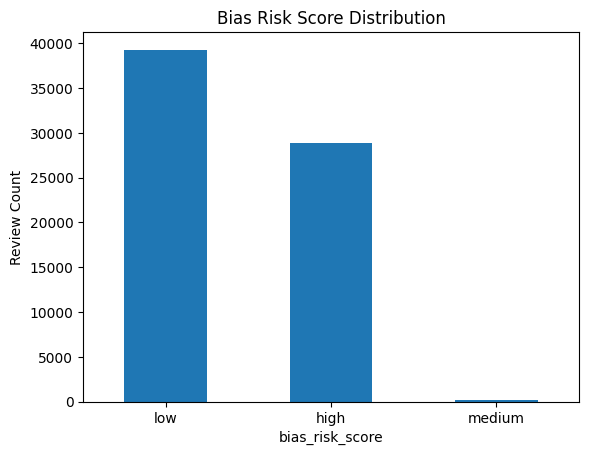

In [22]:
import matplotlib.pyplot as plt

# Count risk categories
risk_counts = flagged_reviews['bias_risk_score'].value_counts()

# Plot
risk_counts.plot(kind='bar', title='Bias Risk Score Distribution', ylabel='Review Count')
plt.xticks(rotation=0)
plt.savefig(f'{save_dir}/Bias_Risk_Score_Distribution.png')
plt.show()


Figure 7: This chart shows how reviews flagged for bias are categorized into high, medium, and low risk. Most high-risk reviews combine both negative language and unfair treatment indicators — highlighting the need for closer scrutiny of these interactions within hospitality services.